<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# Modal analysis of 1D compound systems using DSM - Notebook 4.1
    
In this notebook we formulate the governing equations, and derive the transient response of a frame structure consisting of an Euler Bernoulli horizontal beam (girder), supported by two Euler Bernouli beams (columns) using the Modal Analysis. The beams are assumed inextensible for simplicity.

The studied problem contains anaytical derivations which are discussed in-class and numerical implementations in Python. Follow the class instructions for all analytical derivations.

#### Home exercises:
Once you have been through this notebook try to tackle the following (more) challenging problems: 
1. How would you tackle the same problem if the beams were assumed extensible, i.e. beam-rod elements?
2. How would you solve the same frame if that would include distributed springs/dashpots in part of the structure?

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.optimize as opt
import pydynsm as PDM

## Problem description
The problem that is solved in this excersise containts three EB beams that are connected as shown in the figure below:

<figure>
    <img src="Frame structure - lecture.png" 
         WIDTH=500 
         ALIGN=centre
         alt="Example: Frame structure subjected to general loading.">
    <figcaption> <center> <b>Example: Frame structure subjected to general loading.
    </figcaption>
</figure>
        
The left column is subjected to a distributed force, while the girder is excited by a point load applied at $x=x_0$. The columns share the same material properties; girder is assumed to have different bending rigidity and distributed mass per unit length. The properties of the columns and girder are described by $EI_C$ and $\rho A_C$, and $EI_G$ and $\rho A_G$, respectively. The displacement of the girder is indicated by $W$ while the displacemnt of the columns is given by $U$. 

## 1) Formulation of the governing equations
Formulate the governing equations of the system, including the equations of motions of both bars, the boundary and/or interface conditions. This questions is standard and will also be asked in the assignment which is going to be graded. Please make sure you know very well how to formulate the governing equations of a given problem.

### 1.1) Equations of motion
Since we want to solve this problem using the Modal Analysis, it is convenient to include all forces in the equation of motion. This resultes at three equations of motions; one for the (horizontal) girder and two for the columns, i.e.:

$EI_G w^{(4)}(x,t) + \rho A_G \ddot{w}(x,t)= P(t) \delta(x-x_1)\quad$ at $ x_0<x<x_2, y=y_1$<br>
$EI_C u_1^{(4)}(y,t) + \rho A_c \ddot{u}_{1}(y,t)=q_1(y,t) \quad$ at $ x=x_0, y_0<y<y_1$<br>
$EI_C u_2^{(4)}(y,t) + \rho A_c \ddot{u}_{2}(y,t)=0\quad$ at $ x=x_2, y_0<y<y_1$<br>

### 1.2) Boundary Conditions (BCs) and Interface Conditions (ICs)
At $x=x_0, y=y_0$:<br>
$u_{1}(y_0,t) = 0$<br>
$u_{1}'(y_0,t) = 0$

At $x=x_2, y=y_0$:<br>
$u_{2}(y_0,t) = 0$<br>
$u_{2}'(y_0,t) = 0$

At $x=x_0, y=y_1$:<br>
$u_1'(y_1,t)= w'(x_0,t)$<br>
$-EI_C u_1''(y_1,t)= -EI_G w''(x_0,t) \quad \rightarrow \quad \frac{EI_C}{EI_G} u_1''(y_1,t) - w''(x_0,t) = 0 $<br>
$w(x_0,t) = 0$

At $x=x_2, y=y_1$:<br>
$u_2'(y_1,t)= w'(x_2,t)$<br>
$-EI_C u_2''(y_1,t) -EI_G w''(x_2,t) = 0\quad \rightarrow \quad \frac{EI_C}{EI_G} u_2''(y_1,t) + w''(x_2,t) = 0 $<br>
$w(x_2,t) = 0$

at $x=x, y=y_1$<br>
$u_1(y_1,t)=u_2(y_1,t)$<br>
$-EI_C u_1'''(y_1,t)-EI_C u_2'''(y_1,t) = -m_G \ddot{u}_1(y_1,t) \quad \rightarrow \quad u_1'''(y_1,t)+u_2'''(y_1,t) = \frac{m_G}{EI_C} \ddot{u}_1(y_1,t) $<br>
See that in this last equation, the mass of the girder is included as a interface condition, with $m_G = \rho A_G (x_2-x_0)$



## 2) Eigenvalue problem
To solve the eigenvalue problem, we introduce the following parameters:

In [2]:
x_0=0
x_1=6
x_2=8

y_0=0
y_1=6

E = 210e9
rho = 7850

EI_G = 2e5
I_G = EI_G/E
W_G = EI_G/10
rhoA_G = 60
A_G = rhoA_G/rho


EI_C = 8e4
I_C = EI_C/E
W_C = EI_C/10
rhoA_C = 40
A_C = rhoA_C/rho


f = 20
Omega = 2 * np.pi * f

P_0 = 70
Q_1 = 5

### 2.1) Assumed solution
To obtain the characteristic equation, i.e. the equation the solution of which determines the natural frequencies of the system, we assume a response in the form below:
$w(x,t) = W(x)e^{i\omega t},$ <br>
$u_{i}(y,t) = U_{i}(y)e^{i\omega t}, \qquad i=1,2$ <br>
$P(t) = P_0e^{i\omega t},$ <br>
$q(x,t) = Q_1e^{i\omega t},$ <br>

Please note that at this stage the frequency $\omega$ is a free running (and still undetermined) parameter. Substitution of the assumed solution into the equations of motion yields:<br>
$EI_G W^{(4)}(x) - \omega^2\rho A_G W(x)=P_0\delta(x-x_1)\quad$ at $ x_0<x<x_2, y=y_1$<br>
$EI_C U_1^{(4)}(y) - \omega^2\rho A_c U_{1}(y)=Q_1 \quad$ at $ x=x_0, y_0<y<y_1$<br>
$EI_C U_2^{(4)}(y) - \omega^2\rho A_c U_{2}(y)=0\quad$ at $ x=x_2, y_0<y<y_1$<br>

### 2.2) Homogeneous solutions
The homogeneous solution, i.e. no forces, corresponding to the equations of motion are:<br>
$W = C_{11} e^{-\beta_G (x - x_0)} + C_{12} e^{\beta_G (x - x_2)} + C_{13} e^{-i \beta_G (x - x_0)} + C_{14}  e^{i \beta_G   (x - x_2)}$<br>
$U_1 = C_{21} e^{-\beta_C (y - y_0)} + C_{22} e^{\beta_C (y - y_1)} + C_{23} e^{-i \beta_C (y - y_0)} + C_{24}  e^{i \beta_C (y - y_1)}$<br>
$U_2 = C_{31} e^{-\beta_C (y - y_0)} + C_{32} e^{\beta_C (y - y_1)} + C_{33} e^{-i \beta_C (y - y_0)} + C_{34}  e^{i \beta_C  (y - y_1)}$<br>


The wavenumbers $\beta_G$ and $\beta_C$ are:<br>
$\beta_G^4 = \frac{\omega^2 \rho A_G}{ EI_G}$<br>
$\beta_C^4 = \frac{\omega^2 \rho A_C}{EI_C}$

### 2.3) Derivation of the final matrix equation
Substituting the general solutions in the boundary and interface conditions gives the boundary value problem (check the correspondent Maple file for the matrix derivation):


Initialize assembler of DSM here:


In [3]:
Assembler = PDM.Assembler
s1 = Assembler('Frame')

Assembler 'Frame' successfully initialised


In [4]:
def BVP(ww):
    return s1.GlobalConstrainedStiffness(ww)

### 2.5) Eigenfrequencies
Eigenfrequencies are found by setting the determinant of the coefficient matrix to zero. For a real-valued function we can find that by looking to a change of sign of the determinant. If we generalize this for complex numbers, we are looking for a jump in the argument of Pi. This is extremely helpfull since the absolute value of the determinant can grow rapidly. 

In [5]:
f = np.linspace(1e-4, 200, 10001)
omega = 2* np.pi * f

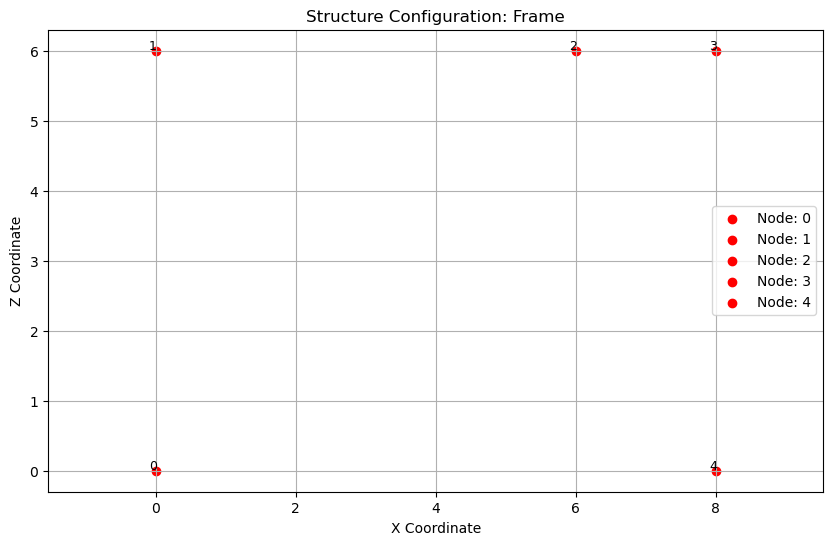

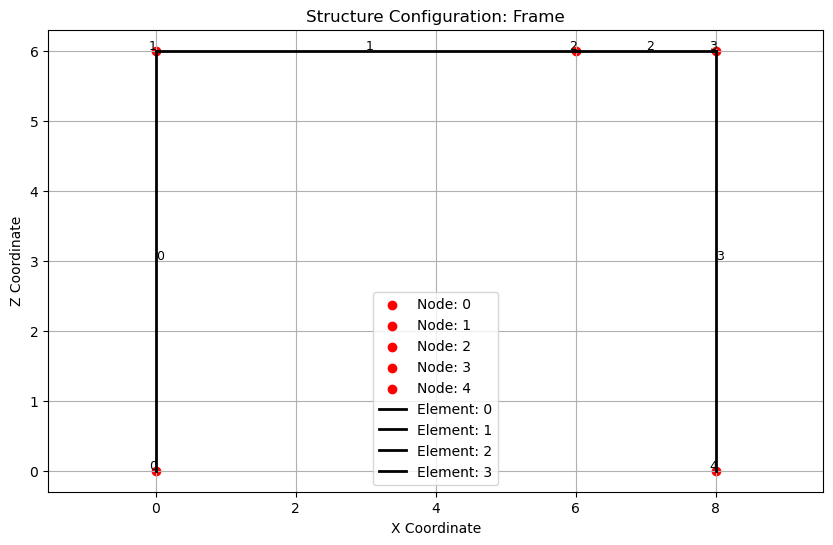

Global DOF 'x' for node 0 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 0 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 0 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Global DOF 'x' for node 4 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 4 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 4 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Successfully added element of type: EulerBernoulli Beam to Element 0
Successfully added element of type: EulerBernoulli Beam to Element 1
Successfully added element of type: EulerBernoulli Beam to Element 2
Successfully added element of type: EulerBernoulli Beam to Element 3
Successfully added element of type: Rod to Element 0
Successfully added element of type: Rod to Elemen

In [6]:
# draw the frame

nodes = []

nodes.append(s1.CreateNode(0,0))
nodes.append(s1.CreateNode(0,y_1))
nodes.append(s1.CreateNode(x_1,y_1))
nodes.append(s1.CreateNode(x_2,y_1))
nodes.append(s1.CreateNode(x_2,0))


s1.PlotStructure()

elements = []

elements.append(s1.CreateElement([nodes[0],nodes[1]]))
elements.append(s1.CreateElement([nodes[1],nodes[2]]))
elements.append(s1.CreateElement([nodes[2],nodes[3]]))
elements.append(s1.CreateElement([nodes[3],nodes[4]]))
s1.PlotStructure(plot_elements=True)


nodes[0].fix_node('x','z','phi_y')
nodes[4].fix_node('x','z','phi_y')


# assign parameters
column = {}
column['E'] = E
column['A'] = A_C
column['Ib'] = I_C
column['Wb'] = W_C
column['ksi'] = 0
column['rho'] = rho

beam = {}
beam['E'] = E
beam['A'] = A_G
beam['Ib'] = I_G
beam['Wb'] = W_G
beam['ksi'] = 0
beam['rho'] = rho

rodb = {}
rodb['E'] = 1*E
rodb['A'] = A_G
rodb['ksi'] = 0
rodb['rho'] = rho

rodc = {}
rodc['E'] = 1*E
rodc['A'] = A_C
rodc['ksi'] = 0
rodc['rho'] = rho

# assign sections
elements[0].SetSection('EulerBernoulli Beam', column)
elements[1].SetSection('EulerBernoulli Beam', beam)
elements[2].SetSection('EulerBernoulli Beam', beam)
elements[3].SetSection('EulerBernoulli Beam', column)

elements[0].SetSection('Rod', rodc)
elements[1].SetSection('Rod', rodb)
elements[2].SetSection('Rod', rodb)
elements[3].SetSection('Rod', rodc)

In [7]:
# some useful functions to find the eigenfrequencies
def det_func(ww):
  dets = np.linalg.det(BVP(ww))
  return dets

def find_eigen_frequencies(omega):
    Det_M = np.array([det_func(ww) for ww in omega])
    omega_initial = omega[np.where(np.isclose(abs(np.diff(np.angle(Det_M)))/np.pi,1, atol=.1))[0]]
    omega_m = []
    for ww in omega_initial:
        omega_m.append(opt.newton(det_func,ww).real)
    return np.unique(omega_m)

def remove_close_roots(roots, tol=1e-6):
    '''
    The function removes close roots from the array of root-finders
    '''
    roots = np.sort(roots)
    filtered_roots = [roots[0]]

    for i in range(1, len(roots)):
        if not np.isclose(roots[i], filtered_roots[-1], atol=tol):
            filtered_roots.append(roots[i])

    return np.array(filtered_roots)

In [8]:
s1.run_connectivity()

f = np.linspace(1e-4, 200, 10001)
omega_range = 2* np.pi * f
omega_m = np.array(find_eigen_frequencies(omega_range))
omega_m = remove_close_roots(omega_m)


In [9]:
Det_M = np.array([det_func(omega) for omega in omega_range])
arg_dets = np.angle(Det_M)

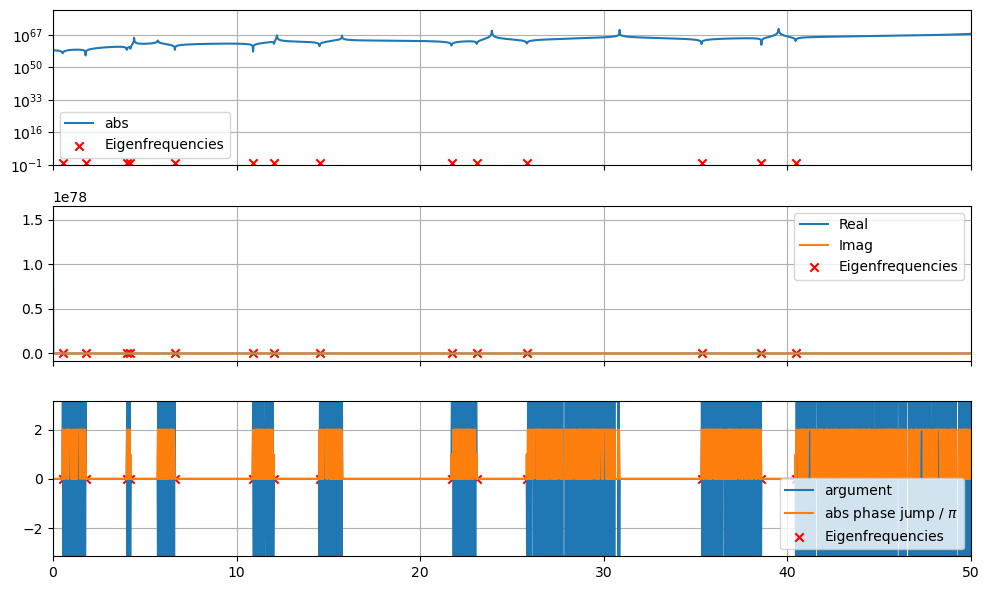

In [10]:
fig, axs = plt.subplots(3, sharex=True,figsize=(10,6))
axs[0].plot(omega / 2 / np.pi,abs(Det_M), label='abs')
axs[0].set_yscale('log')
axs[1].plot(omega / 2 / np.pi,Det_M.real/omega**6, label='Real')
axs[1].plot(omega / 2 / np.pi,Det_M.imag/omega**6, label='Imag')
axs[2].plot(omega / 2/ np.pi, arg_dets, label='argument')
axs[2].plot(omega[:-1] / 2/ np.pi, abs(np.diff(arg_dets))/np.pi, label='abs phase jump / $\pi$')
axs[2].set_ylim([-np.pi, np.pi])

axs[0].scatter(omega_m / 2  / np.pi, np.ones_like(omega_m),marker='x', c='r' , label='Eigenfrequencies')
axs[1].scatter(omega_m / 2  / np.pi, np.zeros_like(omega_m),marker='x', c='r' , label='Eigenfrequencies')
axs[2].scatter(omega_m / 2  / np.pi, np.zeros_like(omega_m),marker='x', c='r' , label='Eigenfrequencies')
for ax in axs.flat:
    ax.grid()
    ax.legend()
    ax.set_xlim([0,50])

axs[0].set_ylim(bottom=1e-1)

#axs[0].set_ylabel('Determinant')
#axs[1].set_ylabel('Determinant / $\omega^6$')
#axs[2].set_ylabel('phase ($-\pi$ to $\pi$)')
#plt.rcParams['figure.figsize'] = [5,10]
plt.tight_layout()

As explained in the before, it can be rather difficult to find the roots numerically. Even though the determinant can be normalized by $omega^6$, it is way easier to look at the phase plot and determine the "jumps" in the phase plot. To refresh your interpretation of complex numbers, the phase is the angle of the complex number running from $0$ -> $2\pi$ (0->360 degree). This means that the phase can exit the plot above in the bottom and re-enter at the top and viceversa. This is plotted as a jump of $2\pi$ but actually is a continuation of the angle around a full cricle. The jumps of $\pi$ on the other hand indicate a change in the sign of the complex function, i.e. a zero crossing, which corresponds to an eigenfrequency.  

### 2.6) Derivation of the eigenmodes (natural modes of vibration)
Once the eigenfrequencies are obtained, the corresponding eigenmodes can be found. This is achieved by replacing a homogenoeus boundary condition by a non-homogeneous boundary condition that is valid for the problem. This approach is identical to the one in which one solves (n-1) out of the n-equations to obtain amplitude ratios (check slides in relevant lectures). 

In this case we will add a vertical loading to node 2 at $(x_1,y_1)$ to obtain eigenmodes.

#### Plot eigenmodes
Let us now compute and visualize the first 6 eigenmodes:

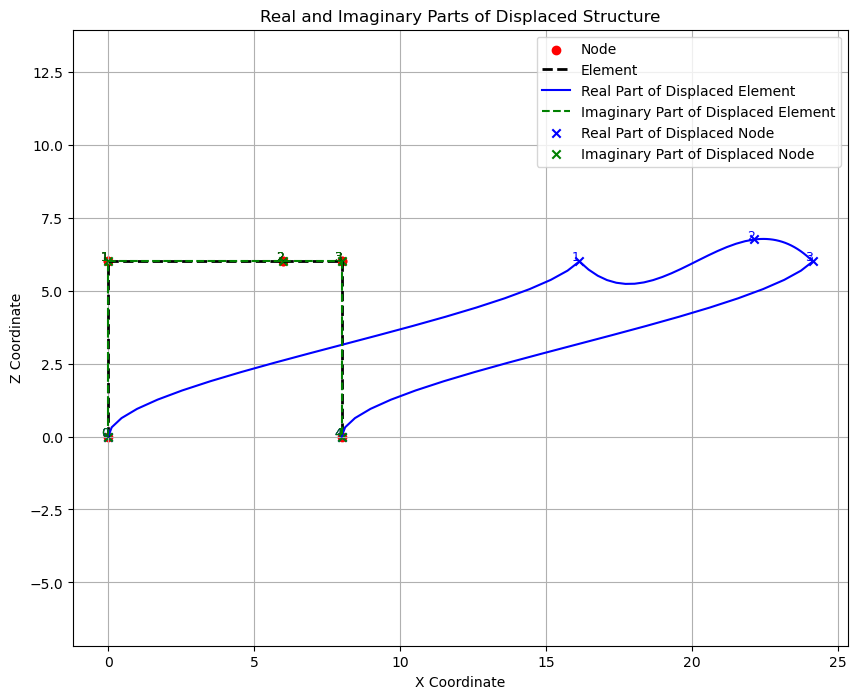

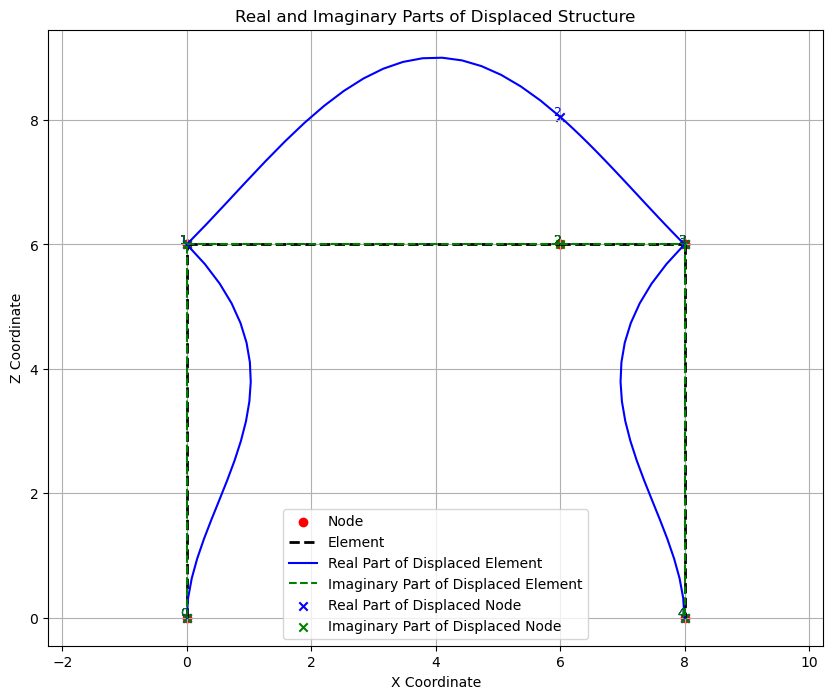

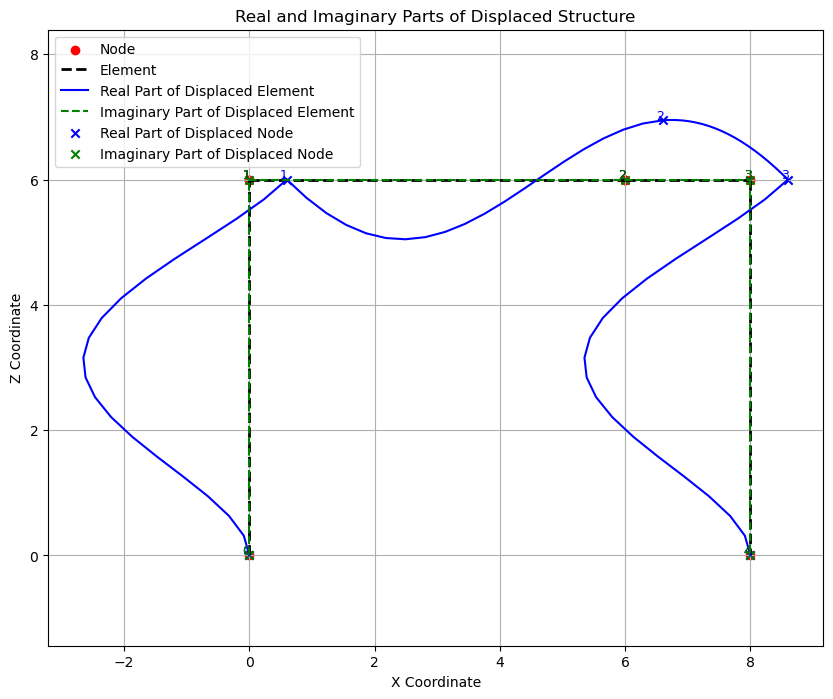

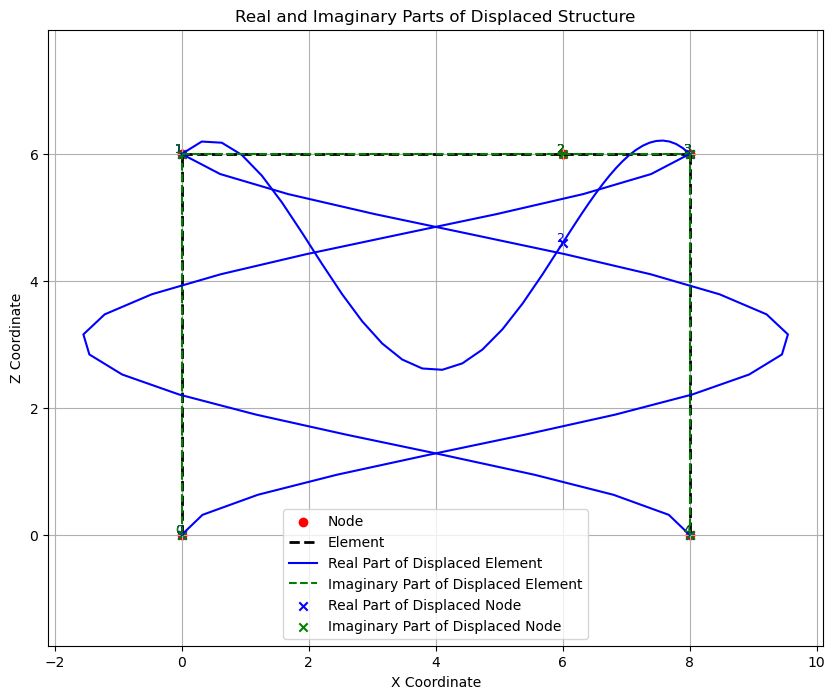

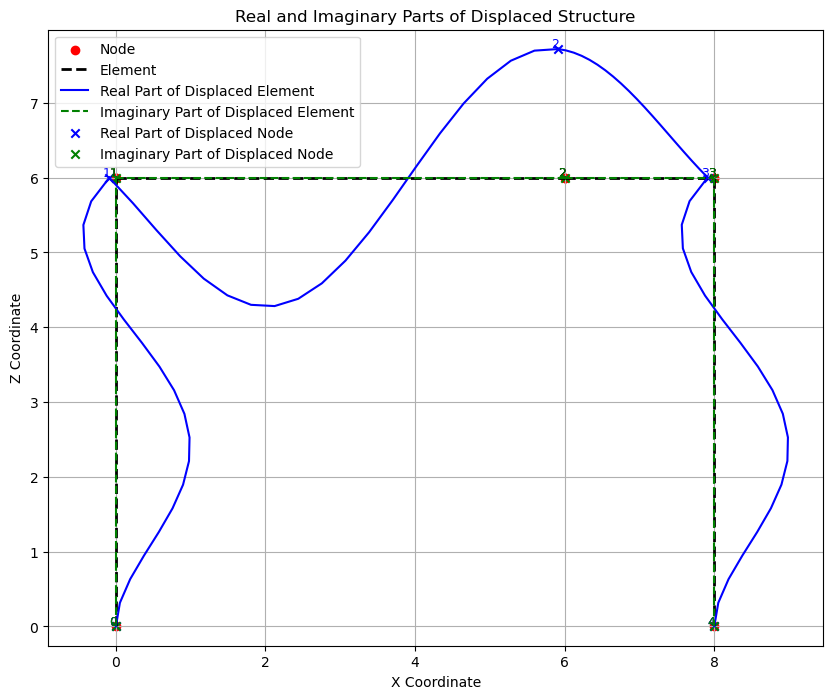

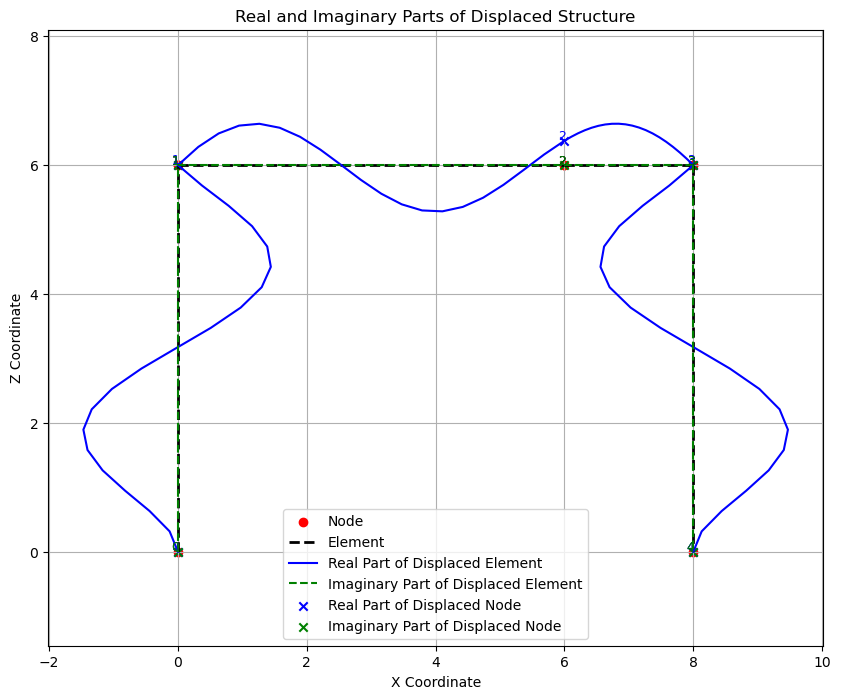

In [11]:
for omega in omega_m[:6]:
    Kc_global = s1.GlobalConstrainedStiffness(omega)
    # solve for the eigenvector by setting one component to amplitude 1
    u_free = s1.SolveUfree(Kc_global[:-1,:-1], -Kc_global[:-1,-1])
    u_free = np.concatenate((u_free, np.array([1])))
    u_elem = s1.FullDisplacement(u_free)
    disp = s1.ElementDisplacements(u_elem,omega)
    s1.PlotElementDisplacements(disp)

That does not look too nice! All modes vary in scale. Let us normalize the modes. 

## 3) The orthogonality of the modes
First, let us derive the general orthogonality relation for a set of continuous systems. We start with the set of equations of motions:<br>
$-\mathbf{EI}(\mathbf{x}) \mathbf{U}^{(4)}(\mathbf{x}) + \omega^2\mathbf{\rho A}(\mathbf{x})\mathbf{U}(\mathbf{x}) =0$<br>
in which $\mathbf{x}$ is the spacial  location, $\mathbf{U}(\mathbf{x},t)$ contains the displacements and, $\mathbf{EI}(\mathbf{x})$ and $\mathbf{\rho A}(x)$ contain the stiffnesses and distributed masses.

Once the natural frequencies, $\omega_m$, and normal modes, $\mathbf{U}_m$, are found, we consider two different normal modes and drop the spacial dependency for convenience:<br>
$-\mathbf{EI} \mathbf{U}_i^{(4)} + \omega_i^2\mathbf{\rho A}\mathbf{U}_i =0 \qquad -\mathbf{EI} \mathbf{U}_j^{(4)} + \omega_j^2\mathbf{\rho A}\mathbf{U}_j =0 $

If we premultiply the first equation by $\mathbf{U}_I$ and the second by $\mathbf{U}_j$ and integrate over the full structure, we get:<br>
$-\int\mathbf{EI} \mathbf{U}^T_j\mathbf{U}_i^{(4)} \text{d}\mathbf{x} + \omega_j^2\int\mathbf{\rho A}\mathbf{U}^T_j\mathbf{U}_i \text{d}\mathbf{x}=0$ <br>
$-\int\mathbf{EI} \mathbf{U}^T_i\mathbf{U}_j^{(4)} \text{d}\mathbf{x} + \omega_j^2\int\mathbf{\rho A}\mathbf{U}^T_i\mathbf{U}_j\text{d}\mathbf{x}=0$ 

substracting the two equations above gives:<br>
$(\omega_i^2 - \omega_j^2) \int\mathbf{\rho A}\mathbf{U}^T_i\mathbf{U}_j\text{d}\mathbf{x} = \int\mathbf{EI} \mathbf{U}^T_i\mathbf{U}_j^{(4)} \text{d}\mathbf{x} - \int\mathbf{EI} \mathbf{U}^T_j\mathbf{U}_i^{(4)} \text{d}\mathbf{x}$

The right hand-side will drop after integration by parts, thus we obtain:<br>
$(\omega_i^2 - \omega_j^2) \int\mathbf{\rho A}\mathbf{U}^T_i\mathbf{U}_j\text{d}\mathbf{x} = 0$<br>
This results in the general orthogonality relation of two modes: <br>
$\int\mathbf{\rho A}\mathbf{U}^T_i\mathbf{U}_j\text{d}\mathbf{x} = 0$ when $\omega_i \neq \omega_j$<br>
$\int\mathbf{\rho A}\mathbf{U}^T_i\mathbf{U}_j\text{d}\mathbf{x} = \Gamma_i $ when $\omega_i = \omega_j$

In our specific case, this reads:<br>
$\rho A_C\int_{y_0}^{y_1} U_{1j}(y) U_{1i}(y) \text{d}y + \rho A_G\int_{x_0}^{x_2} W_{j}(x)W_{i}(x) \text{d}x + \rho A_C\int_{y_0}^{y_1} U_{2j}(y) U_{2i}(y) \text{d}y +m_G  U_{1j}(y_1)U_{1i}(y_1)  = \Gamma_i \delta_{ij}$<br>
Hence that the last term is the mass of the upper bar times its horizontal displacement. The girder is considered a point mass in the vertical axis since it only exists at 1 vertical location (y=y_1), therefore the integral over the domain reduces to the evaluation at the point.

First we will normalize the modes such that $\Gamma_i = 1$

In [12]:
def get_local_coordinates(elements,num):
    coor_local = {}
    for element in elements:
        coor_local[element.id] = element.L*np.linspace(0,1,num)
    return coor_local

def Normalize_modes(Omega,displacement,local_coordinates):
    disp_norm = {}
    for omega in Omega:
        Gamma =  (
            rho*A_C * np.trapz(displacement[omega][elements[0].id][0]**2,local_coordinates[elements[0].id]) + # horizontal disp left column
            rho*A_C * np.trapz(displacement[omega][elements[0].id][1]**2,local_coordinates[elements[0].id]) + # vertical disp left column
            rho*A_G * np.trapz(displacement[omega][elements[1].id][1]**2,local_coordinates[elements[1].id]) + # vertical disp left girder
            rho*A_G * np.trapz(displacement[omega][elements[1].id][0]**2,local_coordinates[elements[1].id]) + # horizontal disp left girder
            rho*A_G * np.trapz(displacement[omega][elements[2].id][1]**2,local_coordinates[elements[2].id]) + # vertical disp right girder
            rho*A_G * np.trapz(displacement[omega][elements[2].id][0]**2,local_coordinates[elements[2].id]) + # horizontal disp right girder
            rho*A_C * np.trapz(displacement[omega][elements[3].id][0]**2,local_coordinates[elements[3].id]) + # horizontal disp right column
            rho*A_C * np.trapz(displacement[omega][elements[3].id][1]**2,local_coordinates[elements[3].id])  # vertical disp right column
        )
                 
        disp_norm[omega] = {elem: disp / np.sqrt(Gamma) for elem, disp in displacement[omega].items()}
    return disp_norm

In [13]:
# firstly create a dictionary for storing the displacements of each mode
disp_dict = {}
num = 8000
for omega in omega_m:
    Kc_global = s1.GlobalConstrainedStiffness(omega)
    u_free = s1.SolveUfree(Kc_global[:-1,:-1], -Kc_global[:-1,-1])
    u_free = np.concatenate((u_free, np.array([1])))
    u_elem = s1.FullDisplacement(u_free)
    disp = s1.ElementDisplacements(u_elem, omega,num)
    disp_dict[omega] = disp

local_coordinates = get_local_coordinates(elements,num)
disp_norm = Normalize_modes(omega_m,disp_dict,local_coordinates)

Now let us try to plot again the normalised eigenmodes:

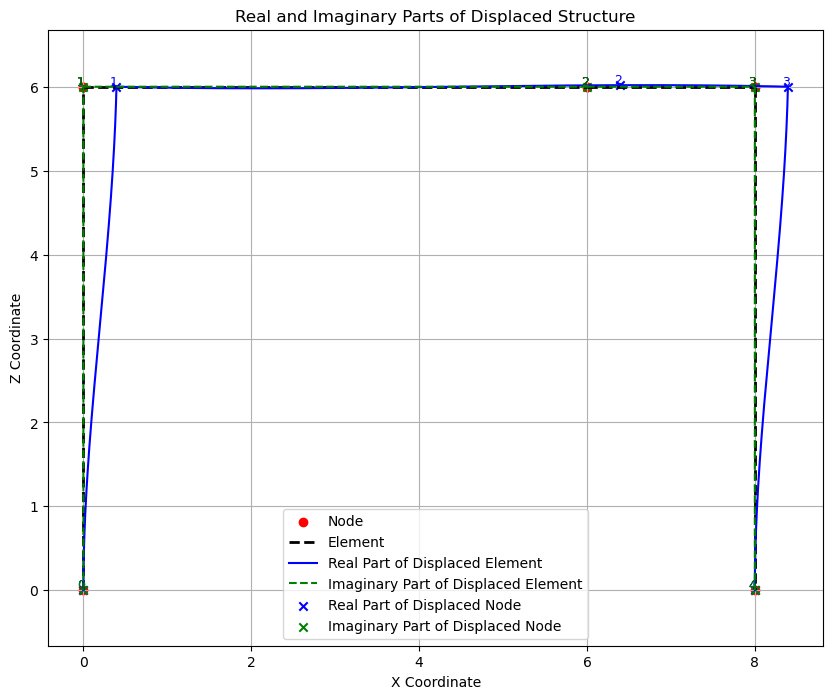

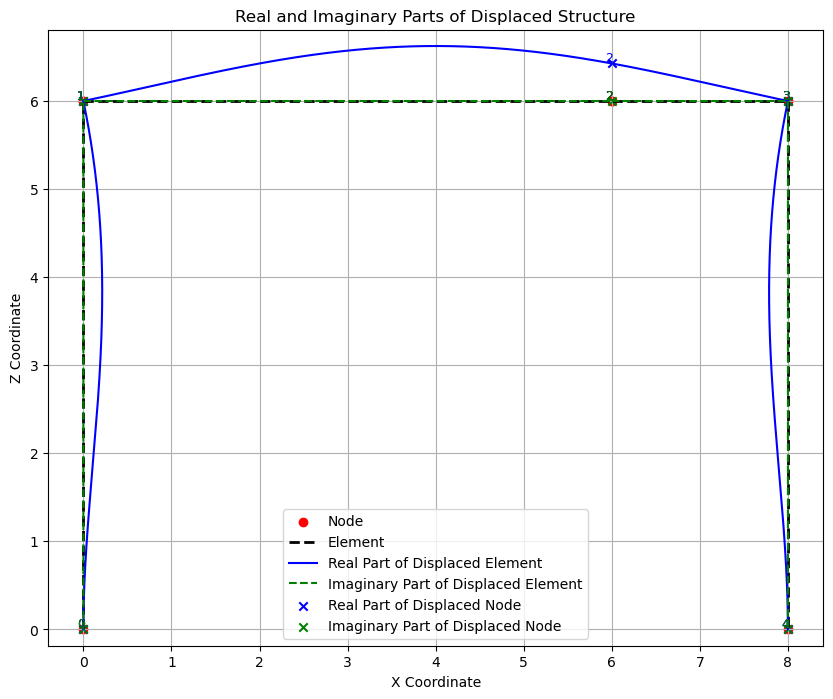

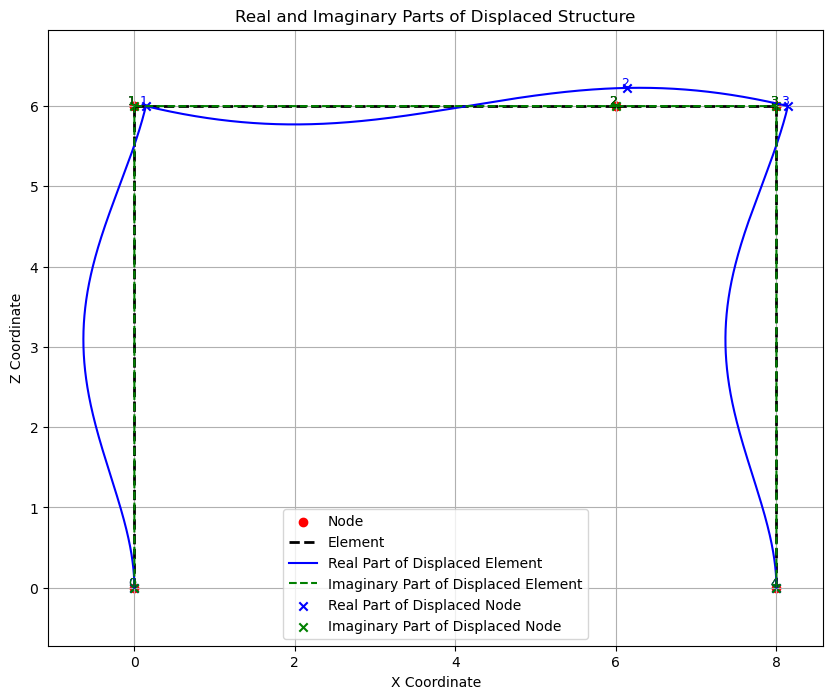

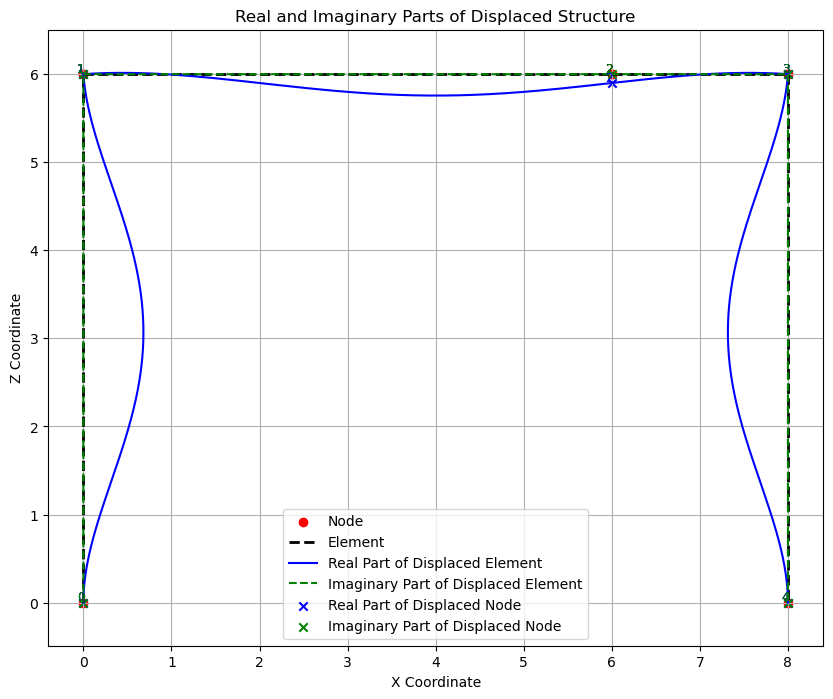

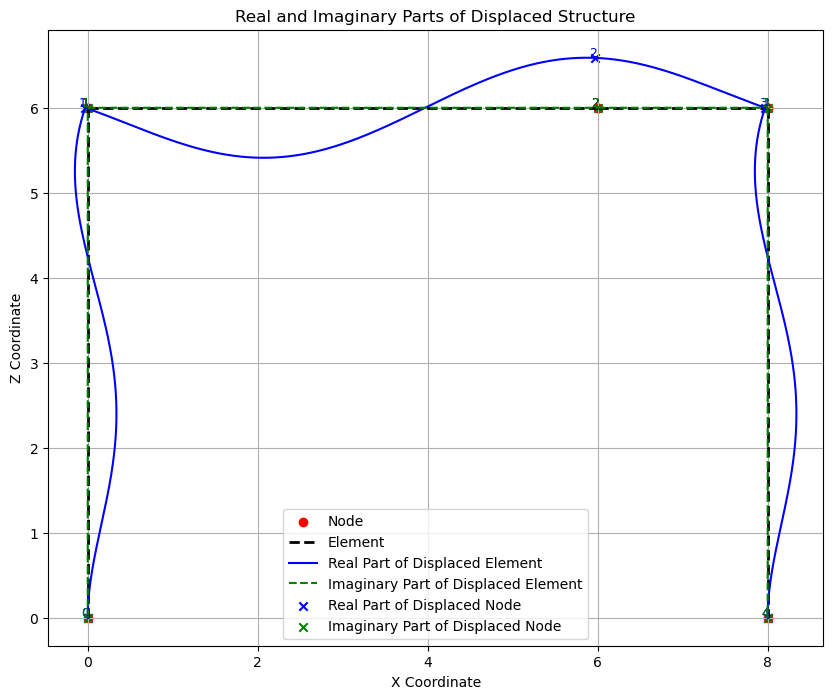

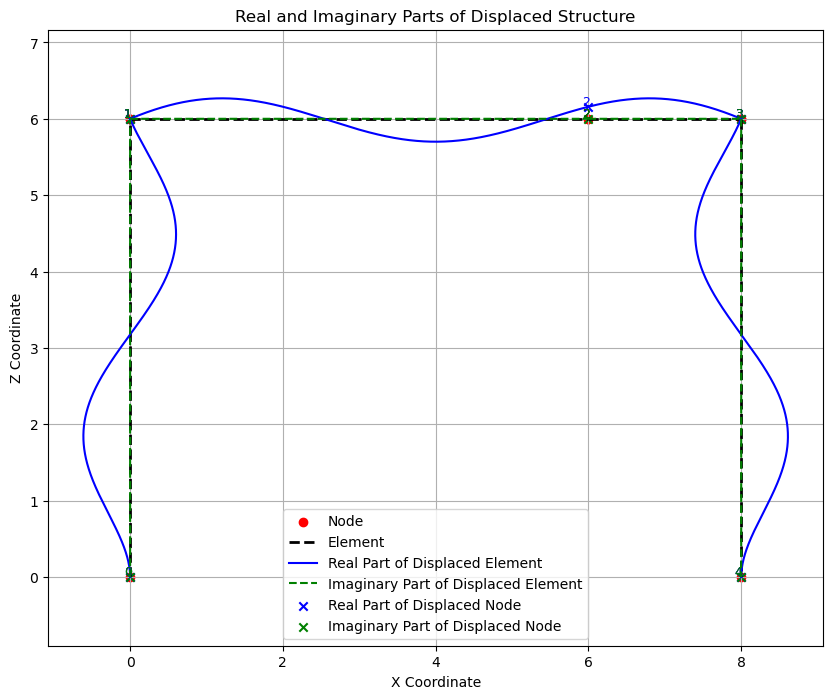

In [14]:
for omega in omega_m[:6]:
    s1.PlotElementDisplacements(disp_norm[omega],scale=10)

Then we should check if the modes are orthogonal with respect to each other.

In [15]:
def Check_Orthogonality(omega,disp_norm,local_coordinates):
    # Get number of omega values
    N = len(omega)
    # Initialize the Ortho matrix
    Ortho_matrix = np.zeros((N,N), dtype=complex)
    # Iterate over indices instead of dictionary keys
    for ii, omega_1 in enumerate(omega):
        for jj, omega_2 in enumerate(omega):
            Ortho_matrix[ii, jj] = (
                # Left column
                rho * A_C * np.trapz(
                    disp_norm[omega_1][elements[0].id][0] * disp_norm[omega_2][elements[0].id][0],
                    local_coordinates[elements[0].id]
                ) +  # Horizontal displacement left column
                rho * A_C * np.trapz(
                    disp_norm[omega_1][elements[0].id][1] * disp_norm[omega_2][elements[0].id][1],
                    local_coordinates[elements[0].id]
                ) +  # Vertical displacement left column
            
                # Left girder
                rho * A_G * np.trapz(
                    disp_norm[omega_1][elements[1].id][0] * disp_norm[omega_2][elements[1].id][0],
                    local_coordinates[elements[1].id]
                ) +  # Horizontal displacement left girder
                rho * A_G * np.trapz(
                    disp_norm[omega_1][elements[1].id][1] * disp_norm[omega_2][elements[1].id][1],
                    local_coordinates[elements[1].id]
                ) +  # Vertical displacement left girder
            
                # Right girder
                rho * A_G * np.trapz(
                    disp_norm[omega_1][elements[2].id][0] * disp_norm[omega_2][elements[2].id][0],
                    local_coordinates[elements[2].id]
                ) +  # Horizontal displacement right girder
                rho * A_G * np.trapz(
                    disp_norm[omega_1][elements[2].id][1] * disp_norm[omega_2][elements[2].id][1],
                    local_coordinates[elements[2].id]
                ) +  # Vertical displacement right girder
            
                # Right column
                rho * A_C * np.trapz(
                    disp_norm[omega_1][elements[3].id][0] * disp_norm[omega_2][elements[3].id][0],
                    local_coordinates[elements[3].id]
                ) +  # Horizontal displacement right column
                rho * A_C * np.trapz(
                    disp_norm[omega_1][elements[3].id][1] * disp_norm[omega_2][elements[3].id][1],
                    local_coordinates[elements[3].id]
                )   # Vertical displacement right column
            )


    return Ortho_matrix

Ortho_coeff = Check_Orthogonality(omega_m[:15],disp_norm,local_coordinates)

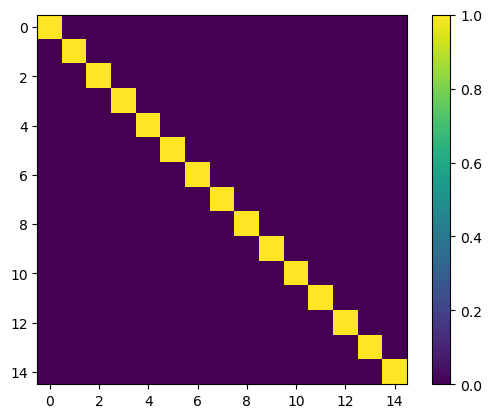

In [16]:
plt.imshow(abs(Ortho_coeff))
plt.colorbar()

The matrix is perfectly diagonal, thus the orthogonality holds!

## 4) Obtain the response per excitation frequency
To derive the frequency response of a forced system. The orthogonality can be used to obtain the modal amplitudes. In the class, we explained how to obtain the (uncoupled) modal equations in the time domain. These can be solved by a standard ODE solver for any given initial conditions. Usually in practice initial conditions are zero and the system contains some damping. If that is the case, a solution by using the FFT method is also very elegant and in fact yields uncoupled algebraic equations in the modal domain. Below we elaborate further on this method. At home, you may wish to try to solve the time domain modal equations directly to obtain the same response.

We start with the equations of motion and substitute the modal expansions at the frequency of excitation $\Omega$:
Substitution of these into the equations of motion yields:<br>
$\sum_i \eta_i \left(EI_G W_{i}^{(4)}(x) - \Omega^2\rho A_G W_{i}(x)\right)=P_0\delta(x-x_1)$ <br>
$\sum_i \eta_i \left(EI_C U_{1i}^{(4)}(y) - \Omega^2\rho A_c U_{1i}(y)\right)=Q_1 $ <br>
$\sum_i \eta_i \left(EI_C U_{2i}^{(4)}(y) - \Omega^2\rho A_c U_{2i}(y)\right)=0$<br>
in which $\eta_i$ is the modal amplitude we are looking for.

We pre-multiply each equation with another mode and integrate over the domain:<br>
$\sum_i \eta_i \int_{x_0}^{x_2}W_{j}(x)\left(EI_G W_{i}^{(4)}(x) - \Omega^2\rho A_G W_{i}(x)\right)\text{d}x=\int_{x_0}^{x_2}W_{j}(x)P_0\delta(x-x_1)\text{d}x $<br>
$\sum_i \eta_i \int_{y_0}^{y_1}U_{1j}(y)\left(EI_C U_{1i}^{(4)}(y) - \Omega^2\rho A_c U_{1i}(y)\right)\text{d}y=\int_{y_0}^{y_1}U_{1j}(y)Q_1 \text{d}y$<br>
$\sum_i \eta_i \int_{y_0}^{y_1}U_{2j}(y)\left(EI_C U_{2i}^{(4)}(y) - \Omega^2\rho A_c U_{2i}(y)\right)\text{d}y=0$


If we then add all three equations and add the mass of the girder in the horizontal direction, we can make use of the same derivation as in deriving the orthogonality relation to simplify the equations above:<br>
$\sum_i \eta_i (\omega_i^2 -\Omega^2 )\left(\rho A_G\int_{x_0}^{x_2} W_{j}(x)W_{i}(x) \text{d}x + \rho A_C\int_{y_0}^{y_1} U_{1j}(y) U_{1i}(y) + U_{2j}(y) U_{2i}(y) \text{d}y + m_G U_{1j}(y_1)U_{1i}(y_1))\right) = P_0W_{j}(x_1) + Q_1 \int_{y_0}^{y_1}U_{1j}(y)\text{d}y$

Making use of the orthogonality relation:<br>
$\sum_i \eta_i (\omega_i^2 -\omega^2 )\Gamma_{i}\delta_{ij} = P_0W_{j}(x_1) + Q_1 \int_{y_0}^{y_1}U_{1j}(y)\text{d}y$<br>
$\eta_i (\omega_i^2 -\omega^2 )\Gamma_{i} = P_0W_{i}(x_1) + Q_1 \int_{y_0}^{y_1}U_{1i}(y)\text{d}y$<br>
$\eta_i =\frac{1}{(\omega_i^2 -\omega^2 )\Gamma_{i}}\left( P_0W_{i}(x_1) + Q_1 \int_{y_0}^{y_1}U_{1i}(y)\text{d}y\right)$

Thus, a very easy to solve equation remains to evaluate the modal amplitude coefficients $\eta_i$. Please note that the latter are complex-valued in the frequency domain. The forces that are examined are predefined in the parameters above. By using the normalized modes, $\Gamma_i = 1$. The modal amplitudes then are:

In [17]:
# MODAL ANALYSIS
N_modes = len(omega_m)
eta_i = np.zeros(N_modes,complex)
for ii, ww in enumerate(omega_m):
    eta_i[ii] = 1 / (ww**2 - Omega**2) *(P_0*disp_norm[ww][elements[1].id][1][-1] +\
                                         Q_1*np.trapz(disp_norm[ww][elements[0].id][0],local_coordinates[elements[0].id]))

In [18]:
FRF = {}
for ii, ww in enumerate(omega_m[:30]):
    eta = eta_i[ii]
    FRF[ww] =  {elem: disp * eta for elem, disp in disp_norm[ww].items()}
FRF_total = {}
for ww, contributions in FRF.items():
    for elem, value in contributions.items():
        FRF_total[elem] = FRF_total.get(elem, 0) + value

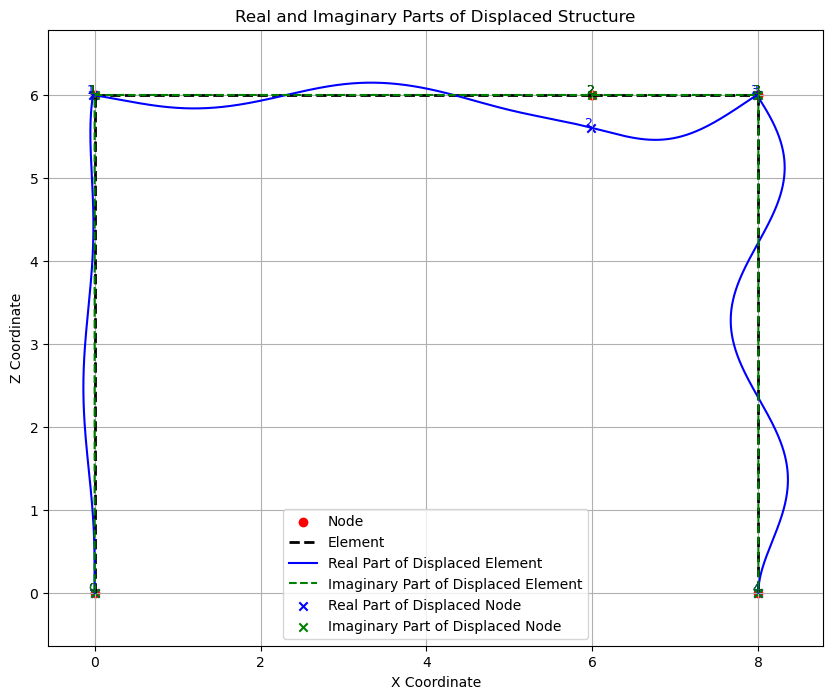

In [19]:
s1.PlotElementDisplacements(FRF_total,scale=1e4)

## Time domain response obtained via the Fourier Transform (FFT)
In this section we will find the time domain response of the distributed q load and a point load (P). The load a smooth variant on a single sinusoidal load, given by the function below. The load and its fourier transform are shown below. 

In [20]:
def force_time(Amp,f0,t0,t): 
    return Amp*(1-np.cos(2*np.pi*f0*(t-t0)))*np.sin(2*np.pi*f0*(t-t0))*(t>t0)*((t-t0)<1/f0)

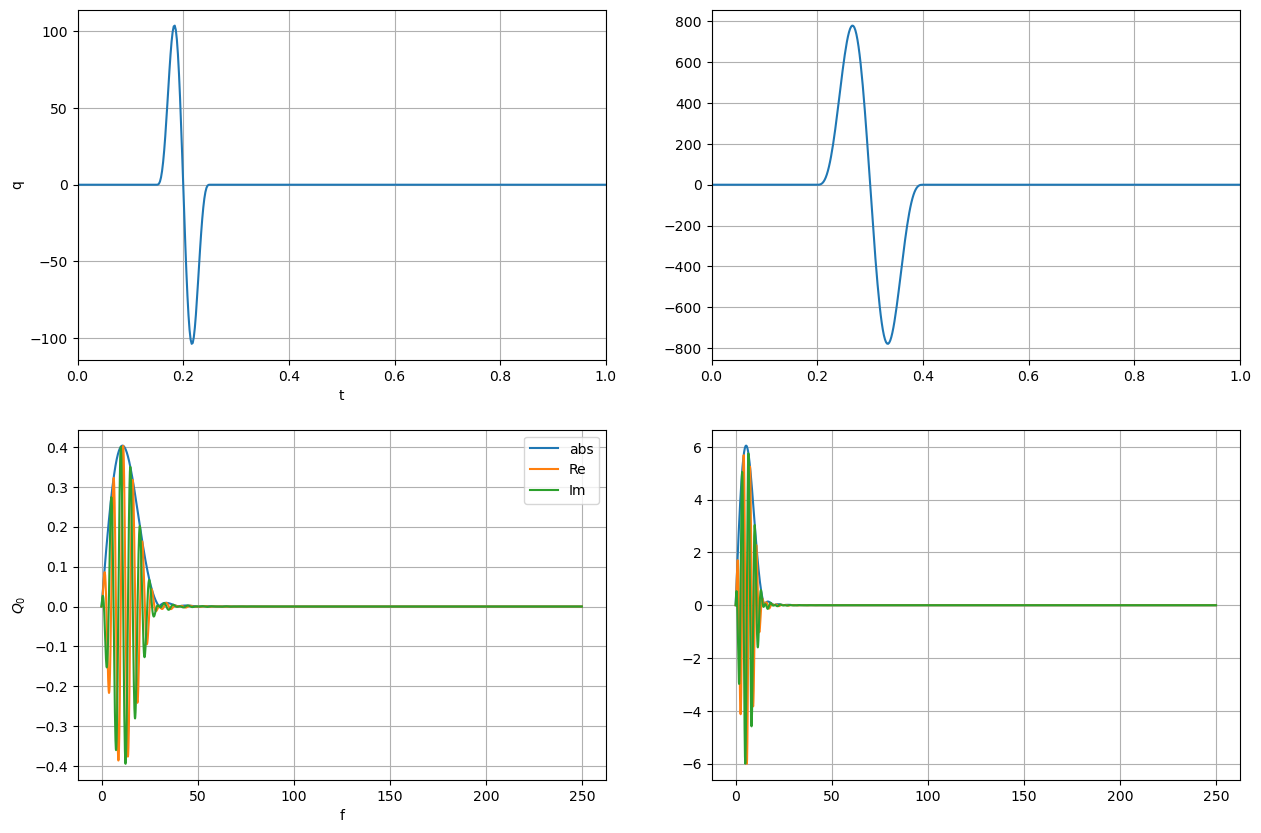

In [21]:
t=np.linspace(0,20,10000,endpoint=False)
N = len(t)
q_load_time = force_time(80,10,0.15,t) 
P_load_time = force_time(600,5,0.2,t) 
Q_omega = fft.rfft(q_load_time)   * 2  / N
P_omega = fft.rfft(P_load_time)   * 2  / N

freq = fft.rfftfreq(N,t[1])
fig,axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].plot(t,q_load_time)
axs[0,0].set_xlim([0,1])
axs[1,0].plot(freq,abs(Q_omega))
axs[1,0].plot(freq,np.real(Q_omega))
axs[1,0].plot(freq,np.imag(Q_omega))
axs[0,1].plot(t,P_load_time)
axs[0,1].set_xlim([0,1])
axs[1,1].plot(freq,abs(P_omega))
axs[1,1].plot(freq,np.real(P_omega))
axs[1,1].plot(freq,np.imag(P_omega))
for ax in axs.flat:
    ax.grid()
axs[0,0].set_xlabel('t')
axs[0,0].set_ylabel('q')
axs[1,0].set_xlabel('f')
axs[1,0].set_ylabel('$Q_0$')
axs[1,0].legend(['abs','Re', 'Im'])
omega = 2 * np.pi * freq
omega[0] = 1e-3 # Approach 0 frequency that gives a numerical error, because of dividing by 0.  

### Find the response at the center of the girder and of the left column
The response is asked at the center of the girder and at the center of the left column, thus at (x=x2/2, y=y1) and (x=0, y=y1/2). First the responses to a unit distributed load (Q) and a unit point load (P) are found in W and U1 at the specified location.

In [26]:
# MODAL ANALYSIS
N_modes = len(omega_m)
eta_ij = np.empty((len(freq),N_modes),complex)

for ii, ww in enumerate(omega):
    for jj, wn in enumerate(omega_m):
        eta_ij[ii,jj] = 1 / ((wn*(1+1j*0.05))**2 - (ww)**2) *(P_omega[ii]*disp_norm[wn][elements[1].id][1][-1] +\
                                            Q_omega[ii]*np.trapz(disp_norm[wn][elements[0].id][0],local_coordinates[elements[0].id]))

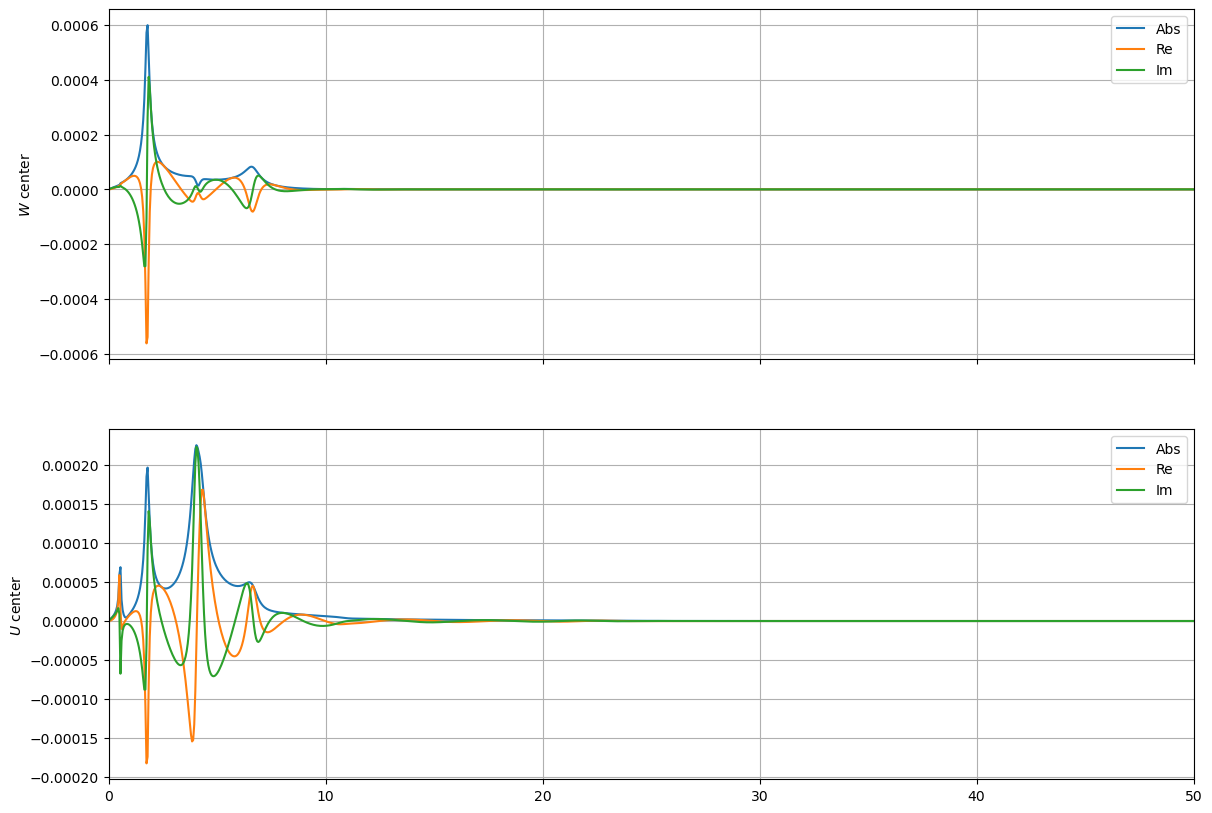

In [27]:
W_center = np.zeros((len(omega),1),complex)  # Initialize 
U1_center = np.zeros((len(omega),1),complex)  # Initialize
for ii, ww in enumerate(omega):
    w = []
    u = []
    for jj, wn in enumerate(omega_m):
         w.append(disp_norm[wn][elements[1].id][1][num//2]*eta_ij[ii,jj])
         u.append(disp_norm[wn][elements[0].id][0][num//2]*eta_ij[ii,jj])
    W_center[ii] = np.sum(w)
    U1_center[ii] = np.sum(u)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(14,10))
axs[0].plot(freq,abs(W_center),label='Abs')
axs[0].plot(freq,W_center.real,label='Re')
axs[0].plot(freq,W_center.imag,label='Im')
axs[0].set_ylabel('$W$ center')
axs[1].plot(freq,abs(U1_center),label='Abs')
axs[1].plot(freq,U1_center.real,label='Re')
axs[1].plot(freq,U1_center.imag,label='Im')
axs[1].set_ylabel('$U$ center')

for ax in axs.flat:
    ax.grid()
    ax.legend(loc='best')
    ax.set_xlim([0,50])

### Inverse Fourier transform
Hereafter, we search for the time domain response by taking the inverse fourier transform

In [28]:
w1_center = fft.irfft(W_center.ravel()) * N /2
u1_center = fft.irfft(U1_center.ravel()) * N /2

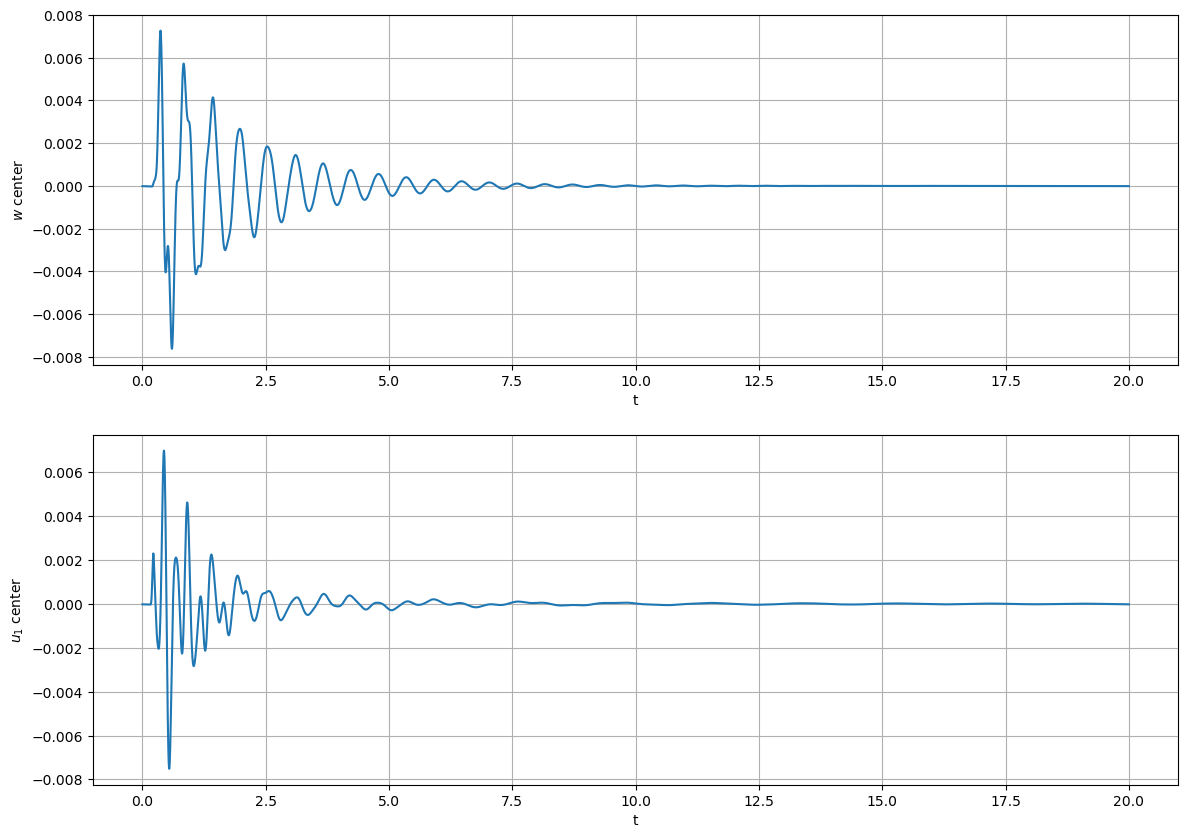

In [29]:
fig, axs = plt.subplots(2,figsize=(14,10))
axs[0].plot(t, w1_center)
axs[1].plot(t, u1_center)

for ax in axs.flat:
    ax.grid()
    ax.set_xlabel('t')

axs[0].set_ylabel('$w$ center')
axs[1].set_ylabel('$u_1$ center')
plt.show()